In [2]:
# 导入一些包
import numpy as np
import pandas as pd

def createDataSet():
    row_data = {'accompany':[1,1,1,0,0],
                'game':[1,1,0,1,1],
                'education':[0,2,1,2,2],
                'label':[1,1,0,0,0]}
    dataSet = pd.DataFrame(row_data)
    return dataSet
dataSet = createDataSet()
dataSet

,accompany,game,education,label
0,1,1,0,1
1,1,1,2,1
2,1,0,1,0
3,0,1,2,0
4,0,1,2,0


In [4]:
def calEnt(dataSet):
    label = dataSet.iloc[:, -1]
    p = label.value_counts()/label.shape[0]
    ent = (-p * np.log2(p)).sum()
    return ent

In [5]:
def bestSplit_silly(dataSet):
    baseEnt = calEnt(dataSet)                                # 计算原始熵
    bestGain = 0                                             # 初始化信息增益
    axis = -1                                                # 初始化最佳切分列，标签列
    for i in range(dataSet.shape[1]-1):                      # 对特征的每一列进行循环
        levels= dataSet.iloc[:,i].value_counts().index       # 提取出当前列的所有取值
        ents = 0                                             # 初始化子节点的信息熵
        for j in levels:                                     # 对当前列的每一个取值进行循环
            childSet = dataSet[dataSet.iloc[:,i]==j]         # 某一个子节点的dataframe
            ent = calEnt(childSet)                           # 计算某一个子节点的信息熵
            ents += (childSet.shape[0]/dataSet.shape[0])*ent # 计算当前列的信息熵
            #print(f'第{i}列的信息熵为{ents}')
        infoGain = baseEnt-ents                              # 计算当前列的信息增益
        #print(f'第{i}列的信息增益为{infoGain}')
        if (infoGain > bestGain):
            bestGain = infoGain                              # 选择最大信息增益
            axis = i                                         # 最大信息增益所在列的索引
    return axis

In [6]:
# 新的办法
dataSet

,accompany,game,education,label
0,1,1,0,1
1,1,1,2,1
2,1,0,1,0
3,0,1,2,0
4,0,1,2,0


In [7]:
baseEnt = calEnt(dataSet)
baseEnt

0.9709505944546686

In [8]:
col = 'accompany'
list(dataSet.groupby(col))

[(0,    accompany  game  education  label
  3          0     1          2      0
  4          0     1          2      0),
 (1,    accompany  game  education  label
  0          1     1          0      1
  1          1     1          2      1
  2          1     0          1      0)]

In [15]:
# 首先选取出一个特征，尝试使用gourpby.apply的方式计算一下当前这个特征做切分之后每一个小dataframe的墒
col = 'accompany'

# groupby相当于切出了很多的小dataframe, apply其实就是一个高效的for循环，依次将切出来的这些小dataframe全部传入到calEnt中计算出小df的墒
dataSet.groupby(col).apply(lambda df : calEnt(df))

# 上面是使用groupby.apply的操作对其中一个特征做切分后墒的结算
# 使用列表解析式对所有的特征进行上面的操作
# 并且最后使用pd.concat方式合成在一起，方便观察
child_entropy = pd.concat([dataSet.groupby(col).apply(lambda df : calEnt(df)) for col in dataSet.columns[:-1]], axis = 1)
child_entropy.columns = dataSet.columns[:-1]
child_entropy

,accompany,game,education
0,0.000000,0.0,0.000000
1,0.918296,1.0,0.000000
2,NaN,NaN,0.918296


In [16]:
dataSet

,accompany,game,education,label
0,1,1,0,1
1,1,1,2,1
2,1,0,1,0
3,0,1,2,0
4,0,1,2,0


In [13]:
# 因为我们要做加权平均的操作，所以我们也需要将每个特征的占比取出来,并且也将列名去上去

child_weight= dataSet.iloc[:, :-1].apply(lambda i : i.value_counts(), axis = 0)/dataSet.shape[0]
child_weight.columns = dataSet.columns[:-1]
child_weight

,accompany,game,education
0,0.4,0.2,0.2
1,0.6,0.8,0.2
2,NaN,NaN,0.6


In [18]:


dataSet 

# 利用numpy pandas特性每两个元素相乘，达到加权平均的目的
child_entropy * child_weight

# 加权平均后按列求和算出切分之后的墒
child_weighted_entropy = (child_entropy * child_weight).fillna(0).sum(axis = 0)
child_weighted_entropy

accompany    0.550978
game         0.800000
education    0.550978
dtype: float64

In [19]:
(baseEnt - child_weighted_entropy).idxmax()

accompany    0.419973
game         0.170951
education    0.419973
dtype: float64

In [86]:
def bestSplit(dataSet):
    baseEnt = calEnt(dataSet)
    child_entropy = pd.concat([dataSet.groupby(col).apply(lambda df : calEnt(df)) for col in dataSet.columns[:-1]], axis = 1)
    child_weight= dataSet.iloc[:, :-1].apply(lambda i : i.value_counts(), axis = 0)/dataSet.shape[0]
    child_weighted_entropy = (child_entropy * child_weight).fillna(0).sum(axis = 0)
    return (baseEnt - child_weighted_entropy).idxmax()
bestSplit(dataSet)

0

In [97]:
def mySplit(dataSet,axis,value):
    col = dataSet.columns[axis]
    redataSet = dataSet.loc[dataSet[col]==value,:].drop(col,axis=1)
    return redataSet

In [106]:
def createTree(dataSet):
    featlist = list(dataSet.columns)                        # 提取出数据集所有的列
    classlist = dataSet.iloc[:,-1].value_counts()           # 获取最后一列类标签
    # 判断最多标签数目是否等于数据集行数，或者数据集是否只有一列
    if classlist.values[0]==dataSet.shape[0] or dataSet.shape[1] == 1:
        return classlist.index[0]                           # 如果是，返回类标签
    
    axis = bestSplit(dataSet)                               # 确定出当前最佳切分列的索引
    bestfeat = featlist[axis]                               # 获取该索引对应的特征
    myTree = {bestfeat:{}}                                  # 采用字典嵌套的方式存储树信息
    del featlist[axis]                                      # 删除当前特征
    valuelist = set(dataSet.iloc[:,axis])                   # 提取最佳切分列所有属性值
    for value in valuelist:                                 # 对每一个属性值递归建树
        myTree[bestfeat][value] = createTree(mySplit(dataSet,axis,value))
    return myTree

In [108]:
createTree(dataSet)

{'accompany': {0: 0, 1: {'game': {0: 0, 1: 1}}}}

In [119]:
dataSet

,accompany,game,education,label
0,1,1,0,1
1,1,1,2,1
2,1,0,1,0
3,0,1,2,0
4,0,1,2,0


In [20]:
# 导入数据集

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score

In [21]:
import numpy as np
import pandas as pd

wine = load_wine()
X = wine['data']
y = wine['target']

data = pd.DataFrame(X, columns = wine.feature_names)
data['label'] = y

In [47]:
X.shape

(178, 13)

In [189]:
# 切分数据集
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.3, random_state = 6)

# 实例化模型
clf = DTC(random_state = 4,
          #max_depth = 6,
          #min_samples_split = 4,
          min_samples_leaf = 4
         )
# 训练模型
clf.fit(Xtrain, Ytrain)

# 查看训练集和测试集上的分数
clf.score(Xtrain, Ytrain), clf.score(Xtest, Ytest)

(0.9596774193548387, 0.8703703703703703)

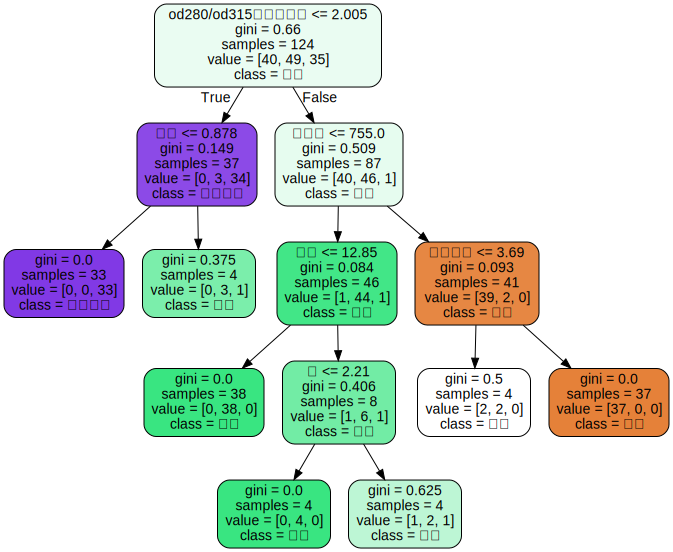

In [198]:
feature_name = ['酒精','苹果酸','灰','灰的碱性','镁',
                '总酚','类黄酮','非黄烷类酚类','花青素',
                '颜色强度','色调','od280/od315稀释葡萄酒','脯氨酸']

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False
import graphviz
dot_data = tree.export_graphviz(clf,
                                out_file = None
                                ,feature_names= feature_name 
                                ,class_names=["琴酒","雪莉","贝尔摩德"] 
                                ,filled=True
                                ,rounded=True)
graph = graphviz.Source(dot_data)
graph

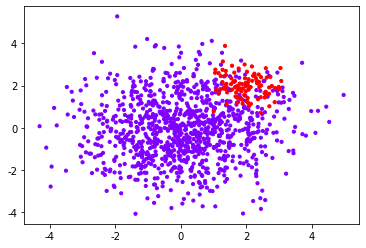

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs

class_1 = 1000 #类别1有1000个样本
class_2 = 100 #类别2只有100个
centers = [[0,0], [2.0, 2.0]] #设定两个类别的中心
clusters_std = [1.5, 0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=420, shuffle=False)

#看看数据集长什么样
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow",s=10);
#其中红色点是少数类，紫色点是多数类

In [223]:
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X, y)

wclf = DecisionTreeClassifier(max_depth=4, 
                              class_weight = 'balanced',
                              #class_weight = {0:1, 1:10}
                             )
wclf.fit(X, y)

clf.score(X, y), wclf.score(X, y)

(0.9581818181818181, 0.9490909090909091)

In [229]:
# 计算当前模型下，少数类样本的准确度

# 首先将数据集的标签预测出来
y_pred = wclf.predict(X)

# 将真实的标签和预测标签拼在一起
results = pd.DataFrame({'True_label': y, 'Pred_label': y_pred})

# 从results中，选取出真实标签为1的样本，也就是少数类的样本
minority = results[results['True_label'] == 1]

# 在少数类的样本当中，对预测的label做一个平均值就可以得到少数类样本的准确率
minority['Pred_label'].mean()

0.99

True Positive: 预测为正(postive),预测正确(预测的结果和真实的结果一样的)

False Negative: 预测为负(negative)，预测错了(预测结果和真实的结果不一样)

False Positive: 预测为正(postive), 预测错了(预测结果和真实的结果不一样)

True Negative: 预测为负(negative),预测正确(预测的结果和真实的结果一样的)

In [234]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

In [231]:
clf_y_pred = clf.predict(X)
wclf_y_pred = wclf.predict(X)

In [236]:
f1_score(y, clf_y_pred), recall_score(y, clf_y_pred), precision_score(y, clf_y_pred), roc_auc_score(y, clf_y_pred)

(0.8050847457627118, 0.95, 0.6985294117647058, 0.9545)

In [235]:
f1_score(y, wclf_y_pred), recall_score(y, wclf_y_pred), precision_score(y, wclf_y_pred), roc_auc_score(y, wclf_y_pred)

(0.7795275590551181, 0.99, 0.6428571428571429, 0.9675)